In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
import subprocess as sp
import os
from scipy.ndimage import interpolation,gaussian_filter,affine_transform
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm,Normalize
import pickle
import time

%matplotlib inline

In [22]:
def specposcorr():
    with fits.open('spectra_positions.fits', mode='update') as hdul:
        data = hdul[0].data
        mask = data > 0
        data[mask] = data[mask]+0.67754*data[mask]**2-1.4464*data[mask]+0.75754
        hdul[0].data = data
        hdul.flush()  # changes are written back to the original file

In [23]:
def wavecalcorr():
    with fits.open('pdt_wave_calib.fits', mode='update') as hdul:
        data = hdul[0].data
        mask = data > 0
        data[mask] = data[mask]-1.766638*data[mask]**3+6.048974*data[mask]**2-6.912795*data[mask]+2.637275
        data[mask] = data[mask]/0.9962
        hdul[0].data = data
        hdul.flush()  # changes are written back to the original file

In [27]:
def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

def extractdata(name,path):
    data = fits.open('%s/%s' %(path,name))
    data = data[0].data
    return data

def science_names(path,header = False):        
    all_filenames = os.listdir(path)
    filenames = []
    for i in range(len(all_filenames)):
        if all_filenames[i].startswith('SPHER'):
            filenames.append(all_filenames[i])
               
    if header == True:
        header_names = []   
        for j in range(len(filenames)):
            if filenames[j].endswith('000.fits'):
                header_names.append(filenames[j])
        return sorted(header_names)
    else:
        return sorted(filenames)
    
def opendatamedian(path,number_cubes):
    namelist = science_names(path)
    data_total = np.zeros(((int(len(namelist)/number_cubes)),39,291,291))
    data_intermed = np.zeros((number_cubes,39,291,291))
    k = 0
    for file in range(len(namelist)):
        data_intermed[k,:,:,:] = extractdata(namelist[file],path)
        k += 1
        if k == number_cubes:
            data_total[int(file/number_cubes),:,:,:] = np.median(data_intermed,axis = 0)
            k = 0
    print(np.shape(data_total))
    return data_total

def opencenter():
    path = '28-3/reducedcenter'
    names = science_names(path)
    data = np.zeros((len(names),39,291,291))
    for name in range(len(names)):
        data[name,:,:,:] = extractdata(names[name],path)
    return data

def extractheader(line,name,path):
    data = fits.open('%s/%s' %(path,name))
    value = data[0].header[line]
    return value

In [5]:
#dataeverything = opendatamedian('28-3/witheverything',5)

datacoro = opendatamedian('28-3/reduced\IFU',5)
#noncorodata = opendatamedian('8-5new/reduced',10)

(16, 39, 291, 291)


In [6]:
def singleplot(data,vmin = 0,vmax = 100,name = None,lognorm = False,cutmin = 0,cutmax = 2050,\
               save = False, color = 'gray',xc = 145,yc = 145, center = False):
    '''shows a single 2d image, if center = true, a small circle is added around the center of the image ''' 
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    if lognorm == True:
        norm = LogNorm(vmin = vmin, vmax = vmax)
    else:
        norm = Normalize(vmin = vmin, vmax = vmax)

    im = ax.imshow(data, cmap = color,norm = norm, origin='lower')
    ax.set_ylim(cutmin,cutmax)
    ax.set_xlim(cutmin,cutmax)
    
    if center == True: #adds a circle around the center pixel
        circ = plt.Circle((xc,yc),4,fill = False,color = 'white') 
        plt.gca().add_artist(circ)
        
    cbaxes = fig.add_axes([0.91, 0.125, 0.025, 0.775]) #position and width of the colorbar
    cb = plt.colorbar(im, cax = cbaxes)
    
    if save == True:
        plt.savefig('%s.png' %(name))

In [7]:
def center_coordinates(data, amplit = False):
    '''fits a gaussian over non coronografic data and determines the position of the center'''
    
    cutmin,cutmax = 100,190 #small square around the star to avoid taking the edge into account 
    y, x = np.mgrid[:cutmax-cutmin, :cutmax-cutmin]
    data = data[cutmin:cutmax,cutmin:cutmax]
    p_init = models.Gaussian2D(x_mean = (cutmax-cutmin)/2, y_mean = (cutmax-cutmin)/2,x_stddev = 2,y_stddev = 2)
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, x,y, data)
    xcoord = p.parameters[1]+cutmin
    ycoord = p.parameters[2]+cutmin
    ampl = p.parameters[0]
    if amplit == False:
        return xcoord,ycoord
    return ampl

def centercoro(datacenteruse,dist = False,ampl = False):
    '''determines the center of an individual centerframe, if ampl == True,
    it returns a cube with all the spots of the raw data, which can be used to 
    calculate the wavelength dependend througput'''
    
    centerx,centery = [108,95,175,190],[191,110,95,178] #
    width = 15
    coordinates = np.zeros((4,2))
    data_end = np.zeros((291,291))
    
    rawspots = np.zeros((4,2*width,2*width))
    for i in range(4):
        y, x = np.mgrid[:width*2, :width*2]
        smoothed_center = gaussian_filter(datacenteruse,sigma = 25)
        extracted_smooth = datacenteruse-smoothed_center
        datafirst = extracted_smooth[centerx[i]-width:centerx[i]+width,centery[i]-
                                     width:centery[i]+width]
        maximum = np.unravel_index(datafirst.argmax(), datafirst.shape)
        newcenter = [centerx[i]+maximum[0]-width,centery[i]+maximum[1]-width]
        data = extracted_smooth[newcenter[0]-width:newcenter[0]+width,
                                newcenter[1]-width:newcenter[1]+width]
        rawspots[i] = datacenteruse[newcenter[0]-width:newcenter[0]+width,newcenter[1]-width:newcenter[1]+width]
        p_init = models.Gaussian2D(x_mean = width, y_mean = width, 
                                   x_stddev = 1.5, y_stddev = 1.5)
        fit_p = fitting.LevMarLSQFitter()
        p = fit_p(p_init,x,y, data)
        coordinates[i,0] = p.parameters[1]+newcenter[0]-width
        coordinates[i,1] = p.parameters[2]+newcenter[1]-width
        data_end[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]= p(x, y)
    middel = np.mean(coordinates,axis = 0)
    distance1 = np.sqrt(np.sum((coordinates[1,:]-coordinates[3,:])**2))
    distance2 = np.sqrt(np.sum((coordinates[0,:]-coordinates[2,:])**2))
    if dist == True:
        return distance1,distance2
    elif ampl == True:
        return middel[0],middel[1],rawspots
    else:
        return middel[0],middel[1]

def corocentercoordinate(centerdata,ampl=True):
    '''determines the precise center by combining mutiple centering frames, if ampl == True, 
    it returns the median amplitude of the spots in each wavelength, for scaling in the SDI routine'''
    
    coordinates = np.zeros((len(centerdata[:,0,0,0]),39,2))
    mask = imcon(np.zeros((30,30)),0,5,15,15)
    mask = np.ones((4,30,30),dtype = 'int')*mask
    
    if ampl == True:
        spots = np.zeros((4,39))
        for data in range(len(centerdata[:,0,0,0])):
            for waveldata in range(len(centerdata[0,:,0,0])):
                coordinates[data,waveldata,0],coordinates[data,waveldata,1],rawspot \
                    = centercoro(centerdata[data,waveldata,:,:],ampl = True)
                spots[data,waveldata] = np.median(rawspot[mask])
        coordinates_mdn = (np.median(coordinates,axis = (0,1)))
        return coordinates_mdn[0],coordinates_mdn[1],np.median(spots,axis = 0)
    
    else:
        for data in range(len(centerdata[:,0,0,0])):
                for waveldata in range(len(centerdata[0,:,0,0])):
                    coordinates[data,waveldata,0],coordinates[data,waveldata,1]\
                        = centercoro(centerdata[data,waveldata,:,:])
        coordinates_mdn = (np.median(coordinates,axis = (0,1)))
        return coordinates_mdn[0],coordinates_mdn[1]

def imcon(im,r_min,r_max,xc, yc):
    '''returns a mask that selects a donut with iner radius r_min, outer radius r_max, with center xc,yc'''
    
    ny, nx = np.shape(im)
    yp, xp = np.mgrid[:ny, :nx]
    yp = yp-yc
    xp = xp-xc
    rmap = np.sqrt(xp**2 + yp**2)
    mask = (rmap <= r_max) * (rmap >= r_min)
    return mask

def shift_center(data,xcoord,ycoord):
    '''shifts an image from center xcoord,ycoord to the center of the image, 145,145'''
    
    data_shifted = interpolation.shift(data,[145-ycoord,145-xcoord])
    return data_shifted

def shift_center_all(data,coro = False):
    '''centers all data in the cube'''
    
    if coro == True:
        centerdata = opencenter()
        center_y,center_x = corocentercoordinate(centerdata,ampl = False)
        
    shifted_data = np.zeros_like(data)
    for i in range(len(data[:,0,0,0])):
        if coro == false:
            center_x,center_y = center_coordinates(data[i,4,:,:])
        for j in range(39):
            shifted_data[i,j,:,:] = shift_center(data[i,j,:,:],center_x,center_y)
    return shifted_data

In [10]:
dataonlydark_sh = shift_corocenters(dataonlydark)
datanothing_sh = shift_corocenters(datanothing)
dataonlylargesc_sh = shift_corocenters(dataonlylargesc)
datawithoutIFU_sh = shift_corocenters(datawithoutIFU)
dataeverything_sh = shift_corocenters(dataeverything)

#corodata_sh = shift_corocenters(datacoro)
#noncorodata_sh = shift_center_all(noncorodata)

In [10]:
ding = np.arange(2*3*4*4).reshape(2,3,4,4)
med = np.median(ding, axis = 0)
print(np.shape(med))
ding - med

(3, 4, 4)


array([[[[-24., -24., -24., -24.],
         [-24., -24., -24., -24.],
         [-24., -24., -24., -24.],
         [-24., -24., -24., -24.]],

        [[-24., -24., -24., -24.],
         [-24., -24., -24., -24.],
         [-24., -24., -24., -24.],
         [-24., -24., -24., -24.]],

        [[-24., -24., -24., -24.],
         [-24., -24., -24., -24.],
         [-24., -24., -24., -24.],
         [-24., -24., -24., -24.]]],


       [[[ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.]],

        [[ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.]],

        [[ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.],
         [ 24.,  24.,  24.,  24.]]]])

In [12]:
def scaling(im, sca, order=2):
    '''scales the image im with given scale sca'''
    
    center = np.array([145,145])
    if sca == 1:
        return(im)
    scale = np.array([[1./sca,0],[0,1./sca]])
    offset_combined = center - center.dot(scale)
    dst=affine_transform(im,scale.T, order=order, offset=offset_combined, output_shape=(291,291), cval=0.0)
    return(dst)

def descale(imin, scalefac):
    '''scales imin at all wavelengths with their scalefactor scalefac, which is an array'''
    
    nim, nx, ny = imin.shape
    sx = np.ones_like(scalefac) * 145
    sy = np.ones_like(scalefac) * 145
    im_out = np.zeros((nim, nx, ny))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = scaling(frame_sq, scalefac[j],)
        im_out[j,:,:] = frame_rot  
    return(im_out)

def rotate(data,names,path):
    '''rotates the image with the parallactic angle, which is taken from the header'''
    
    signal_rotated = np.zeros_like(data)
    for file in range(len(data[:,0,0,0])):
        angle = extractheader('HIERARCH ESO TEL PARANG START',names[file],path)
        for wavel in range(len(data[0,:,0,0])):
            signal_rotated[file,wavel,:,:] = interpolation.rotate(data[file,wavel,:,:],angle*(-1)+100.46,
                                                                  reshape = False)
    return signal_rotated

def ADI_new(data,path,ext = False):
    mag = magnification(ext = ext)
    norm = AOnorm(data,50,75,mag)
    data = data/norm[:,None,None,None]
    names = science_names(path,header = True)
    
    signal = np.zeros((39,291,291))
    
    #print('start with wavelengthbin No. %s' %(i))
    median_bg = np.median(data,axis = 0)
    med_sub = rotate(data-median_bg,names,path)
    mean_sub = np.mean(med_sub,axis = 0)
    signal = mean_sub
    return signal    
    #wfits(signal, 'signal.fits')

def AOnorm(data,r_min,r_max,mag):
    '''corrects for the difference in AO correction between the different cubes, 
    it returns the median of a certain selection of the background, which can be used to scale the images'''
    
    norm = np.zeros((len(data[:,0,0,0]),39))
    for j in range(len(data[:,0,0,0])):
        for i in range(39):
            mask = imcon(data[j,i],r_min/mag[i],r_max/mag[i],145, 145)
            norm[j,i] = np.median(data[j,i,mask])
    norm = np.median(norm,axis = 1)
    return norm 

def magnification(ext = True,stop = 38):
    if ext == True:
        wavels = np.linspace(0.953,1.677,39)
        
    else: 
        wavels = np.linspace(0.953,1.346,39)    
    mag = wavels[stop]/wavels
    return mag

def SDI(path,data,start,stop,coro = True,ext = False):
    '''Applies SDI on the given data, for the wavelengthrange start to stop.'''
    
    names = science_names(path,header = True)
    mag = magnification(ext = ext,stop = stop)
    
    if coro == True:
        norm = AOnorm(data,50,75,mag)
        centerdata = opencenter()
        ycenter,xcenter,amplitudes = corocentercoordinate(centerdata)
    else:
        norm = AOnorm(data,40,80,mag)
        amplitudes = np.zeros((39))
        for k in range(39):
            mask = imcon(data[0,0,:,:],7/mag[k],20/mag[k],145,145)
            amplitudes[k] = np.median(data[:,k,mask])  
    data = data/norm[:,None,None,None]
    sdi_out = np.zeros((len(data[:,0,0,0]),stop-start,291,291))
    for i in range(len(data[:,0,0,0])):
        #print('start with file No. %s ' %(i)) 
            
        descaled = descale(data[i,start:stop,:,:], mag[start:stop])
        sdi_norm = np.zeros_like(descaled)
        
        for k in range(stop-start):
            sdi_norm[k] = descaled[k]/amplitudes[k+start]
            
        sdi_norm_sub = sdi_norm-np.median(sdi_norm,axis = 0)
        for k in range(stop-start):
            sdi_norm_sub[k] = sdi_norm_sub[k]*amplitudes[k+start]
            
        sdi_out[i] = descale(sdi_norm_sub,1./mag[start:stop])

    rotated_sdi = rotate(sdi_out,names,path)
    return rotated_sdi,norm

In [ ]:
ADI

In [105]:
sdinoncor,norm = SDI('8-5new/reduced',noncorodata_sh,20,38,coro = False)

(17, 39, 291, 291) (17,)


In [ ]:
median = np.median(datacoro,axis = (2,3))
data = datacoro - median[:,:,None,None]
path = '28-3/reducedfin'
names = science_names(path,header = True)

angle = np.zeros((16))
for i in range(16):
    angle[i] = extractheader('HIERARCH ESO TEL PARANG START',names[i],path) 

signal = ADI_new(data,path,angle)

In [200]:
path = '28-3/reduced\IFU'
data = corodata_sh #- median[:,:,None,None]
start,stop = 17,38
sdi_outcoro = SDI(path,data,start,stop)

start with file No. 0 
start with file No. 1 
start with file No. 2 
start with file No. 3 
start with file No. 4 
start with file No. 5 
start with file No. 6 
start with file No. 7 
start with file No. 8 
start with file No. 9 
start with file No. 10 
start with file No. 11 
start with file No. 12 
start with file No. 13 
start with file No. 14 
start with file No. 15 


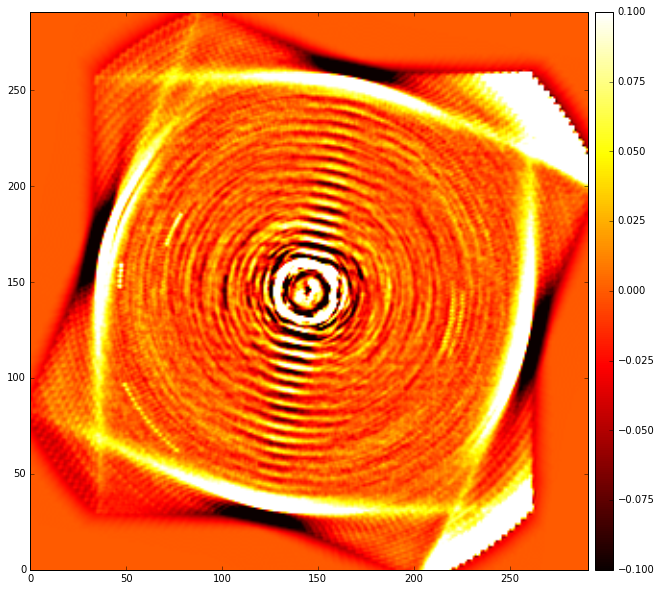

In [212]:
singleplot(np.mean(sdi_outcoro[:,:,:,:],axis = (0,1)),cutmax = 291,vmin = -0.1,vmax = 0.1,color = 'hot')

In [24]:
def showcorosmooth():
    '''shows the coronografic data, smoothed with a gaussian. 
    This is just to show an intermediate step and is not used in the rest of the program'''
    
    datacenter = opencenter()
    showdata_wavel(datacenter[0,:,:,:],'coronodata1',-10,250)
    smoothed_center = gaussian_filter(datacenter[0,:,:,:],sigma = 25)
    extracted_smooth = datacenter[0,:,:,:]-smoothed_center
    showdata_wavel(extracted_smooth,'smoothedcorono1',-10,200)

def headervalue_all(path):
    '''prints all values for a certain header value in the assigned map, this is just 
    for checking which files are in the correct mode and is not used in the rest of the program'''
    
    names = science_names(path)
    for name in range(len(names)):
        wavelmax = extractheader('HIERARCH ESO DRS IFS MAX LAMBDA',names[name],path)
        mode = extractheader('HIERARCH ESO INS4 MODE',names[name],path)
        print(wavelmax,mode,names[name])
        
def showmodelcorocenter():
    datacenter = opencenter()
    datacenteruse = datacenter[0,21,:,:]
    centerx,centery = [108,95,175,190],[191,110,95,178]
    width = 20
    data_end = np.zeros((291,291))
    coordinates = np.zeros((4,2))
    for i in range(4):
        y, x = np.mgrid[:width*2, :width*2]
        smoothed_center = gaussian_filter(datacenteruse,sigma = 25)
        extracted_smooth = datacenteruse-smoothed_center
        datafirst = extracted_smooth[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]
        #plt.imshow(datafirst)
        #plt.figure()
        maximum = np.unravel_index(datafirst.argmax(), datafirst.shape)
        newcenter = [centerx[i]+maximum[0]-width,centery[i]+maximum[1]-width]
        data = extracted_smooth[newcenter[0]-width:newcenter[0]+width,
                                newcenter[1]-width:newcenter[1]+width]
        print(maximum)

        p_init = models.Gaussian2D(x_mean = width, y_mean = width, 
                                   x_stddev = 1.5, y_stddev = 1.5)
        #print(p_init)
        fit_p = fitting.LevMarLSQFitter()
        p = fit_p(p_init,x,y, data)
        coordinates[i,0] = p.parameters[1]+newcenter[0]-width
        coordinates[i,1] = p.parameters[2]+newcenter[1]-width

        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(data, origin='lower', interpolation='nearest', vmin = 0, vmax = 100)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin = 0, vmax = 100)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(data - p(x, y), origin='lower', interpolation='nearest', vmin = 0, vmax = 100)
        plt.title("Residual")
        data_end[centerx[i]-width:centerx[i]+width,centery[i]-width:centery[i]+width]= p(x, y)
        #print(p)
    #print(coordinates)
    middel = np.mean(coordinates,axis = 0)
    plt.figure()
    plt.imshow(extracted_smooth,vmin = -50, vmax = 100)
    print(middel)
    print(coordinates)
    plt.figure()
    plt.imshow(data_end)
    plt.savefig('fit coro data')
    plt.figure()
    plt.imshow(datacenteruse,vmin = -10, vmax = 200)

def showdata_number(data,name,vmins,vmaxs,save = False,lognorm = False,cutmin = 70,cutmax = 220):
    '''shows the data over time'''
    
    fig, axes = plt.subplots(4, 4,figsize=(16,16),sharex=True, sharey=True)
    
    if lognorm == True:
        color = LogNorm(vmins, vmaxs)
    else:
        color = Normalize(vmins,vmaxs)
        
    for number in range(len(data[:,0,0])):
        data_per_number = data[number,:,:]
        ypos = number%4
        xpos = np.int(number/4)
        axes[xpos, ypos].imshow(data_per_number,norm = color,origin='lower')
        axes[xpos, ypos].set_title(number)
    median_value = np.median(data, axis = 0)
    mean_value = np.mean(data, axis = 0)
    #im = axes[1,2].imshow(median_value)
    #axes[1,2].set_title('median')
    #axes[2,3].imshow(mean_value)
    #axes[2,3].set_title('mean')
    fig.subplots_adjust(wspace=0, hspace=0.10)
    #fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle('Cube number dependence', fontsize = 25, x = 0.43)
    #plt.axis([cutmin, cutmax, cutmin, cutmax])
    plt.savefig('number dependence %s.jpg' %(name))
    plt.show()

def showdata_wavel(data, name, vmins,vmaxs,save = False,lognorm = False,cutmin = 70,cutmax = 220): 
    '''#gives an image with at each subplot an image in a different wavelength bin'''
    
    fig, axes = plt.subplots(5,8,figsize=(16,9.5),sharex=True, sharey=True)
    if lognorm == True:
        color = LogNorm(vmins, vmaxs)
    else:
        color = Normalize(vmins,vmaxs)
    wavelmax = 1.677
    wavelengthvalue = np.linspace(0.953,wavelmax,39)
    xas_ticks = 4
    
    for wavelengthbox in range(39):
        data_used = data[wavelengthbox]
        ypos = wavelengthbox%8
        xpos = np.int(wavelengthbox/8)
        axes[xpos,ypos].imshow(data_used,label = wavelengthvalue[wavelengthbox],norm = color,origin='lower')
        axes[xpos, ypos].set_title(r'%s$\mu m$' %(round(wavelengthvalue[wavelengthbox],3)))
        
    fig.subplots_adjust(wspace=0, hspace=0.2)#space between subplots
    
    median_value = np.median(data, axis = 0)
    im = axes[4,7].imshow(median_value,norm = color,origin='lower')
    axes[4,7].set_title('median')
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle('Wavelength dependence', fontsize = 25, x = 0.43)
    plt.xticks(np.round(np.linspace(cutmin,cutmax,xas_ticks),0)) #cosmetics for the x-axis values
    if save == True:
        plt.savefig('wavelength dependence %s.jpg' %(name))
    plt.show()

def plotspecklegrowth():
    '''plots the growth of the speckles over wavelength'''
    
    data = opencenter()
    growthindiv = np.zeros((4,39))
    distance1,distance2 = np.arange(39),np.arange(39) 
    for j in range(4):
        for i in range(len(data[0,:,0,0])):    
            distance1[i],distance2[i] = centercoro(data[j,i,:,:],dist = True)
        growthindiv[j,:] = (distance1/distance1[0] + distance2/distance2[0])/2. 
    growth = np.median(growthindiv,axis = 0)

    x = np.linspace(0.953,1.346,39)/0.953
    x = x[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x-1, growth-1)
    a2,_,_,_ = np.linalg.lstsq(x, growth)
    print(a)
    print(a2)

    plt.figure(figsize=(12, 9))
    plt.plot(np.linspace(0.953,1.346,39)/0.953,growth, label = 'data')
    plt.plot(np.arange(0,1.5,0.1),np.arange(0,1.5,0.1),label = 'expected slope')
    #plt.plot(np.arange(1,1.5,0.1),a*np.arange(1,1.5,0.1)+(1-a), label = 'fit with fixed end with slope %s' 
    #         %(np.round(a[0],3)))
    plt.plot(np.arange(1,1.5,0.1),a2*np.arange(1,1.5,0.1), label = 'fit with slope %s' 
             %(np.round(a2[0],3)))
    plt.legend(loc = 'upper left')
    plt.axis([1,1.4,1,1.4])
    plt.ylabel('relative growth in speckle width')
    plt.xlabel('relative growth in wavelength')
    plt.savefig('specklegrowth.png')
    plt.grid()
    
def show_centerfit(): 
    '''shows a plot of the fitted gaussian that is used to determine the 
    position of the center of the star. The residual is also plotted.'''
    
    cutmin,cutmax = 100,190
    y, x = np.mgrid[:cutmax-cutmin, :cutmax-cutmin]

    data = noncorodata[9,1,:,:]
    data = data[cutmin:cutmax,cutmin:cutmax]
    p_init = models.Gaussian2D(x_mean = (cutmax-cutmin)/2, y_mean = (cutmax-cutmin)/2, x_stddev = 1,y_stddev = 1)
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, x,y, data)

    plt.figure(figsize=(8, 2.5))
    plt.subplot(1, 3, 1)
    plt.imshow(data, origin='lower', interpolation='nearest', vmin=-2, vmax=500)
    plt.title("Data")
    plt.subplot(1, 3, 2)
    plt.imshow(p(x, y), origin='lower', interpolation='nearest', vmin=-2, vmax=500)
    plt.title("Model")
    plt.subplot(1, 3, 3)
    plt.imshow(data - p(x, y), origin='lower', interpolation='nearest', vmin=-2, vmax=500)
    plt.title("Residual")

    xcoord = p.parameters[1]
    ycoord = p.parameters[2]

    print('mean of residual =', np.mean(data - p(x, y)))
    print('median of residual =',np.median(data - p(x, y)))
    print('xcoord =',xcoord,'ycoord =', ycoord)

    print(p_init)
    print(p)
    plt.savefig('gaussian non coro fit.jpg')
    
def opendata(path,number_cubes):
    '''opens all data in a 5D array, is currently unused, since the files are too big to handle'''
    
    namelist = science_names(path)
    data_total = np.zeros(((int(len(namelist)/number_cubes)),number_cubes,39,291,291))
    for file in range(len(namelist)):
        data_per_number = extractdata(namelist[file],path)
        data_total[int(file/number_cubes),file%number_cubes,:,:,:] = data_per_number
    print(np.shape(data_total))
    return np.median(data_total,axis = 1)

In [ ]:
def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output

    # determine centre of input image

    # -0.5 is there for fencepost counting error
    c_in = np.array(offset1) - 0.5
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def derot(imin, rotangle, out_dims, star_cen):
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)

def ADI():
    path = '28-3/reduced\IFU'
    names = science_names(path,header = True)
    shiftedcorodata = pickle.load(open("shiftedcorodata2.p", "rb" ))
    
    referenceprep = np.zeros((4,39,291,291))
    for i in range(4):
        referenceprep[i] = shiftedcorodata[i*4]
    reference = np.median(referenceprep,axis = 0)

    
    #reference = np.median(shiftedcorodata,axis = 0)
    signal_rotated = shiftedcorodata - reference
    signal = rotate(signal_rotated,names,path)
    return signal

In [34]:
'''This block is used to run the esorex reduction pipeline'''

def filenames(path): 
    '''loads the filenames out of each folder'''
    
    directories = ['darks','detectorflats','instrumentflats','specpos',
                   'wavecal','distortmap','science','refstar','preampflat']
    names = []
    for directory in range(len(directories)):
        names.append(sorted(os.listdir("%s/%s" %(path,directories[directory]))))
    return names

def corr(name,values): 
    '''corrects the wavelengthcalibration and spectral positioning file to third order, since the
    pipeline has struggles to do it good at once'''
    
    with fits.open(name, mode='update') as hdul:
        data = hdul[0].data
        mask = data > 0
        data[mask] = data[mask]+values[0]*data[mask]**3+values[1]*data[mask]**2+values[2]*data[mask]+values[3]
        hdul[0].data = data
        hdul.flush()  # changes are written back to the original file

def configcommands(): 
    '''creates commandlines for all calibration data, which are suitable for configuration files'''
    
    path = '28-3'
    names = filenames(path)
    
    #commandlines for raw data
    darks_raw = ['%s/darks/' %(path) + i + ' IFS_DARK_RAW' for i in names[0]]
    detectorflats_raw = ['%s/detectorflats/' %(path) + i + ' IFS_DETECTOR_FLAT_FIELD_RAW' 
                         for i in names[1]]
    instrumentflats_raw = ['%s/instrumentflats/' %(path) + i + ' IFS_FLAT_FIELD_RAW' 
                           for i in names[2]]
    specpos_raw = ['%s/specpos/' %(path) + i + ' IFS_SPECPOS_RAW' for i in names[3]]
    wavecal_raw = ['%s/wavecal/' %(path) + i + ' IFS_WAVECALIB_RAW' for i in names[4]]
    distortmap_raw = ['%s/distortmap/' %(path) + i + ' IFS_DISTORTION_MAP_RAW' 
                      for i in names[5]]
    science_raw = ['%s/science/' %(path) + i + ' IFS_SCIENCE_DR_RAW' for i in names[6]]
    refstar_raw = ['%s/refstar/' %(path) + i + ' IFS_SCIENCE_DR_RAW' for i in names[7]]
    preampflat_raw = ['%s/preampflat/' %(path) + i + ' IFS_DETECTOR_FLAT_FIELD_RAW' for i in names[8]]
    
    #commandlines for reduced calibration data
    master_dark = 'master_dark.fits IFS_MASTER_DARK'
    badpixelmap = 'static_badpixels.fits IFS_STATIC_BADPIXELMAP'
    lamp1 = 'large_scale_flat_l1.fits IFS_MASTER_DFF_LONG1'
    lamp2 = 'large_scale_flat_l2.fits IFS_MASTER_DFF_LONG2'
    lamp3 = 'large_scale_flat_l3.fits IFS_MASTER_DFF_LONG3'
    lamp4 = 'large_scale_flat_l4.fits IFS_MASTER_DFF_LONG4'
    lampBB = 'large_scale_flat_l5.fits IFS_MASTER_DFF_LONGBB'
    lampshort = 'large_scale_flat_l5.fits IFS_MASTER_DFF_SHORT'
    specpos = 'spectra_positions.fits IFS_SPECPOS'
    wavecalib = 'pdt_wave_calib.fits IFS_WAVECALIB'
    IFU_flat = 'ifs_ifu_flat.fits IFS_IFU_FLAT_FIELD'
    distortmap = 'ifs_distortion_map.fits IFS_DISTORTION_MAP'
    preampflat = 'preamp_flat_l5.fits IFS_PREAMP_FLAT'
    instrumentflat = 'ifs_instrument_flat.fits IFS_INSTRUMENT_FLAT_FIELD'
    
    #nested list with all the commandlines for each raw input files
    configrawcommandlines = [darks_raw,detectorflats_raw,instrumentflats_raw,specpos_raw,
                             wavecal_raw,distortmap_raw,science_raw,refstar_raw,preampflat_raw]
    
    #nested list with all the commandlines for all reduced calibration data 
    configreducedcommandlines = [master_dark,badpixelmap,lamp1,lamp2,lamp3,lamp4,lampBB,
                                 specpos,wavecalib,IFU_flat,distortmap,preampflat,instrumentflat,lampshort]
    return configrawcommandlines,configreducedcommandlines

def run_recipes(rawline,reducedline,name,command,option = ''):
    '''general recipe to run esorex'''
    
    rawlines,reducedlines = configcommands()
    configcommandlines = rawlines[rawline]
    for i in reducedline: 
        configcommandlines.append(reducedlines[i])
    np.savetxt(name,configcommandlines, newline='\n', fmt = '%s') #creates configuration file
    sp.run('esorex %s %s %s' %(command,option,name),shell = True) #runs the actual esorex recipe in 
                                                        #the terminal

def run_dark():
    run_recipes(0,[],'configdarks','sph_ifs_master_dark configdarks')

def run_preampflat():
    run_recipes(8,[0,1],'configpreampflat','sph_ifs_master_detector_flat',\
                option = '--ifs.master_detector_flat.save_addprod')
    
def run_detectorflat():
    run_recipes(1,[0],'configdetectorflat','sph_ifs_master_detector_flat',\
                option = '--ifs.master_detector_flat.save_addprod')
    
def run_instrumentflat():
    run_recipes(2,[0,2,3,4,6,7,11],'configinstrumentflat','sph_ifs_instrument_flat')
    
def run_specpos():
    run_recipes(3,[0],'configspecpos','sph_ifs_spectra_positions')
    corr('spectra_positions.fits',[0,0.67754,-1.4464,0.75754])
    
def run_wavecal():
    run_recipes(4,[0,7],'configwavecal','sph_ifs_wave_calib') #0,7,12
    values = [-1.766638,6.048974,-6.912795,2.637275]/0.9962 
    corr('pdt_wave_calib.fits', values)
    
def run_IFUflat():
    run_recipes(2,[0,2,3,4,6,13,8,11],'configIFUflat','sph_ifs_instrument_flat') #11

def run_distortmap():
    run_recipes(5,[0,1,2,3,4,6,8,9,11],'configdistortmap','sph_ifs_distortion_map')

def run_science():
    run_recipes(6,[0,1,2,3,4,6,8,9,11],'configscience','sph_ifs_science_dr') #0,1,2,3,4,6,8,10,11

def run_refstar():
    run_recipes(7,[0,1,2,3,4,6,8,11],'configscience','sph_ifs_science_dr')

#run_dark()
#run_preampflat()
#run_detectorflat()
#run_specpos()
#run_instrumentflat()
run_wavecal()
run_IFUflat()
#run_distortmap()
run_science()
#run_refstar()

TypeError: unsupported operand type(s) for /: 'list' and 'float'